In [1]:
import os
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
from utils.exp_utils import list_concept_names, list_exp_names

In [2]:
class ExpScoreKeeper:
    def __init__(self, base_path, dataset_name, exp_name, model_name, step=None):
        self.base_path = base_path
        self.dataset_name = dataset_name
        self.exp_name = exp_name
        self.model_name = model_name
        self.score_path = f"{base_path}/{dataset_name}/{exp_name}_{model_name}.pkl"
        if step is not None:
            self.score_path = f"{base_path}/{dataset_name}/stepwise/{exp_name}/{exp_name}_{model_name}{step}.pkl"
            self.exp_name = f"{step}"
        
        if not os.path.exists(self.score_path):
            raise FileNotFoundError(f"Score file {self.score_path} does not exist.")
        with open(self.score_path, "rb") as f:
            self.data = pk.load(f)

        self.concept = sorted(list(self.data.keys()))
        for concept in self.concept:
            self.data[concept]['final_score'] = (
                self.data[concept]['consistency_score'] 
                - self.data[concept]['distinction_score']
                + self.data[concept]['relevance_score']
            )

        self.metric = {
            "consistency_score": [],
            "distinction_score": [],
            "relevance_score": [],
            "final_score": [],
            "v0v0": [],
            "v1v1": [],
            "v2v2": [],
            "v0v1": [],
            "v0v2": [],
            "v1v2": []
        }

        for metric in self.metric.keys():
            self.metric[metric] = [
                np.mean([self.data[concept][metric] for concept in self.concept]),
                np.std([self.data[concept][metric] for concept in self.concept])
                ]
    
    def calculate_instree_score(self):
        for concept in self.concept:
            self.data[concept]['instree_score'] = (
                self.data[concept]['consistency_score'] 
                + min(self.data[concept]['v1v1'], self.data[concept]['v2v2'])
                - self.data[concept]['distinction_score']
            )
        self.metric['instree_score'] = [
            np.mean([self.data[concept]['instree_score'] for concept in self.concept]),
            np.std([self.data[concept]['instree_score'] for concept in self.concept])
        ]

    def __str__(self):
        return f"""
Concept: {self.concept}
Concept Length: {len(self.concept)}
Base Path: {self.base_path}
Dataset Name: {self.dataset_name}
Experiment Name: {self.exp_name}
Model Name: {self.model_name}
Final Score: {self.metric['final_score'][0]}
Final Score Std: {self.metric['final_score'][1]}
"""
    
    def show_aspect_score(self):
        print(
f"""
Aspect Scores:
Consistency: {self.metric['consistency_score'][0]}
Distinction: {self.metric['distinction_score'][0]}
relevance: {self.metric['relevance_score'][0]}

Consistency Std: {self.metric['consistency_score'][1]}
Distinction Std: {self.metric['distinction_score'][1]}
relevance Std: {self.metric['relevance_score'][1]}
"""
        )
    
    def show_node_score(self):
        print(
f"""
Node Scores:
V0V0: {self.metric['v0v0'][0]}
V1V1: {self.metric['v1v1'][0]}
V2V2: {self.metric['v2v2'][0]}
V0V1: {self.metric['v0v1'][0]}
V0V2: {self.metric['v0v2'][0]}
V1V2: {self.metric['v1v2'][0]}
V0V0 Std: {self.metric['v0v0'][1]}
V1V1 Std: {self.metric['v1v1'][1]}
V2V2 Std: {self.metric['v2v2'][1]}
V0V1 Std: {self.metric['v0v1'][1]}
V0V2 Std: {self.metric['v0v2'][1]}
V1V2 Std: {self.metric['v1v2'][1]}
"""
        )
        
    def show_concept_score(self, concept):
        if concept not in self.concept:
            raise ValueError(f"Concept {concept} not found in the experiment data.")
        print(
f"""
Scores for concept {concept} in experiment {self.exp_name}:
Consistency: {self.data[concept]['consistency_score']}
Distinction: {self.data[concept]['distinction_score']}
Relevance: {self.data[concept]['relevance_score']}
Final: {self.data[concept]['final_score']}
V0V0: {self.data[concept]['v0v0']}
V1V1: {self.data[concept]['v1v1']}
V2V2: {self.data[concept]['v2v2']}
V0V1: {self.data[concept]['v0v1']}
V0V2: {self.data[concept]['v0v2']}
V1V2: {self.data[concept]['v1v2']}
"""
        )



In [3]:
base_path = "/home/jack/Code/Research/instree_analysis/experiment_image/scores"
exp_path = "/home/jack/Code/Research/instree_analysis/experiments"
dataset_name = "InsData_clip"

exp_names = list_exp_names(dataset_name, exp_path)
cpt_names = list_concept_names(dataset_name)

===== Experiment names for InsData_clip: =====
0 0_InspirationTree
1 1_Proposed
2 2_Abla_Attn
3 2_Abla_Attn_RD
4 2_Abla_Attn_RD_EMA
5 2_Abla_RD
===== Total experiments: 6 =====
===== Concept names for InsData_clip: =====
buddha
canada_bear
cat_statue
colorful_teapot
decoritems_woodenpot
elephant
green_dall
mug_buildings
mug_skulls
physics_mug
plushie_tortoise
red_teapot
round_bird
===== Total concepts: 13 =====


In [4]:
exp_idx = list(range(len(exp_names)))
analysis_name = [exp_names[i] for i in exp_idx]
sk_list = []

for exp_name in analysis_name:
    print(f"Loading {dataset_name} {exp_name}")
    sk_list.append(ExpScoreKeeper(base_path, dataset_name, exp_name, "clip"))

Loading InsData_clip 0_InspirationTree
Loading InsData_clip 1_Proposed
Loading InsData_clip 2_Abla_Attn
Loading InsData_clip 2_Abla_Attn_RD
Loading InsData_clip 2_Abla_Attn_RD_EMA
Loading InsData_clip 2_Abla_RD


In [6]:
exp_idx = [0, 1]
analysis_name = [exp_names[i] for i in exp_idx]
sk_step_dict = {}

for exp_name in analysis_name:
    print(f"Loading Stepwise {dataset_name} {exp_name}")
    sk_temp_list = []
    for step in range(100, 1001, 100):
        sk_temp_list.append(ExpScoreKeeper(base_path, dataset_name, exp_name, "clip", step))
    sk_step_dict[exp_name] = sk_temp_list

Loading Stepwise InsData_clip 0_InspirationTree
Loading Stepwise InsData_clip 1_Proposed


In [6]:
# https://docs.google.com/spreadsheets/d/1MZJcoBtVKAhKgnQlZky_cfkGL1vAevpiiODSi3rdIzs/edit?gid=0#gid=0

def tab_separated_result(sk, name):
    result = [
        sk.metric['consistency_score'][0],
        sk.metric['distinction_score'][0],
        sk.metric['relevance_score'][0],
        sk.metric['final_score'][0],
        sk.metric['v0v0'][0],
        sk.metric['v1v1'][0],
        sk.metric['v2v2'][0],
        sk.metric['v0v1'][0],
        sk.metric['v0v2'][0],
        sk.metric['v1v2'][0]
    ]
    result = [name] + [str(round(r, 4)) for r in result]
    print("\t".join([r for r in result]))


def tab_separated_result_concept(sk):
    for concept in sk.concept:
        result = [
            sk.data[concept]['consistency_score'],
            sk.data[concept]['distinction_score'],
            sk.data[concept]['relevance_score'],
            sk.data[concept]['final_score'],
            sk.data[concept]['v0v0'],
            sk.data[concept]['v1v1'],
            sk.data[concept]['v2v2'],
            sk.data[concept]['v0v1'],
            sk.data[concept]['v0v2'],
            sk.data[concept]['v1v2']
        ]
        result = [concept] + [str(round(r, 4)) for r in result]
        print("\t".join([r for r in result]))

In [8]:
print("Aspect\tConsistency\tDistinction\tRelevance\tFinal Score\tV0V0\tV1V1\tV2V2\tV0V1\tV0V2\tV1V2")

# for sk, name in zip(sk_list, analysis_name):
#     tab_separated_result(sk, name)

for sk, name in zip(sk_list, analysis_name):
    print(name)
    tab_separated_result_concept(sk)
    
# for sk, name in zip(sk_list, analysis_name):
#     print(f"===== Exp: {name} =====")
#     print(sk)
#     sk.show_aspect_score()
#     sk.show_concept_score('red_teapot')

Aspect	Consistency	Distinction	Relevance	Final Score	V0V0	V1V1	V2V2	V0V1	V0V2	V1V2
0_InspirationTree
buddha	1.6331	0.5699	1.4522	2.5154	0.9336	0.7606	0.8725	0.6383	0.8139	0.5699
canada_bear	1.3942	0.519	1.2984	2.1736	0.9662	0.6947	0.6995	0.6543	0.6441	0.519
cat_statue	1.5708	0.5519	1.3594	2.3783	0.9139	0.7849	0.7859	0.6819	0.6775	0.5519
colorful_teapot	1.3848	0.5632	1.3604	2.182	0.9499	0.7783	0.6066	0.7869	0.5735	0.5632
decoritems_woodenpot	1.4008	0.5343	1.1769	2.0433	0.9645	0.7671	0.6337	0.7013	0.4755	0.5343
elephant	1.4662	0.6198	1.1983	2.0447	0.9345	0.7784	0.6878	0.6176	0.5806	0.6198
green_dall	1.349	0.5084	1.1938	2.0344	0.908	0.7613	0.5877	0.5843	0.6094	0.5084
mug_buildings	1.3121	0.4713	1.1681	2.0089	0.93	0.7506	0.5616	0.6616	0.5065	0.4713
mug_skulls	1.259	0.4596	1.0861	1.8856	0.9374	0.7829	0.4761	0.6665	0.4196	0.4596
physics_mug	1.3323	0.487	1.2194	2.0647	0.8256	0.694	0.6383	0.6239	0.5954	0.487
plushie_tortoise	1.546	0.5693	1.3358	2.3126	0.9329	0.7615	0.7845	0.7214	0.6144	0.5693


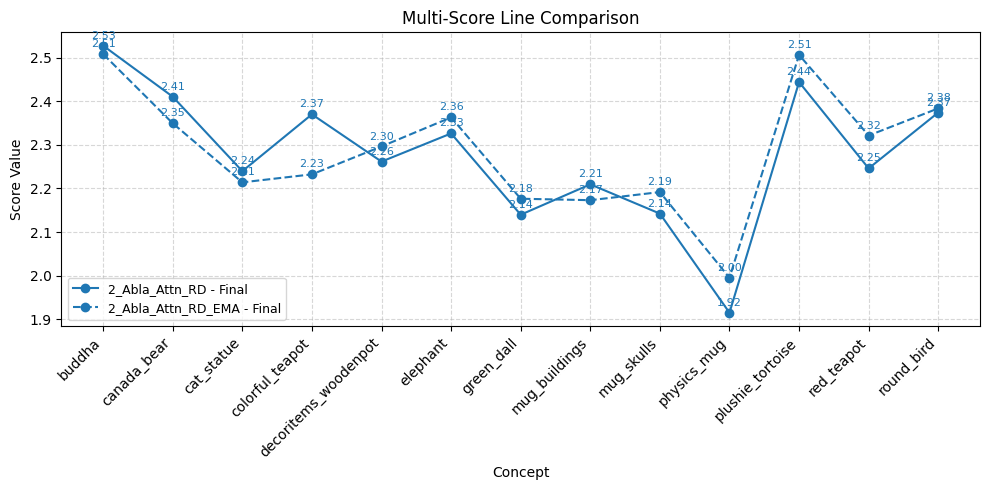

In [15]:
def plot_concept_multi_field_line_comparison_with_labels(dict_list, fields=['consistency', 'distinction', 'relevance'], title='Multi-Score Line Comparison'):
    label_list = [d.exp_name for d in dict_list]
    
    # 找出共通的 concept
    concept_sets = [set(d.concept) for d in dict_list]
    common_concepts = sorted(set.intersection(*concept_sets))
    
    if not common_concepts:
        print("No common concepts to compare.")
        return

    x = np.arange(len(common_concepts))
    fig, ax = plt.subplots(figsize=(10, 5))

    # 顏色與線型設計
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    linestyles = ['-', '--', '-.', ':']

    for i, d in enumerate(dict_list):
        for j, field in enumerate(fields):
            scores = [d.data[c][f"{field}_score"] for c in common_concepts]
            label = f"{label_list[i]} - {field.capitalize()}"
            color = colors[j % len(colors)]
            linestyle = linestyles[i % len(linestyles)]

            # 繪圖
            ax.plot(x, scores, label=label, linestyle=linestyle, marker='o', color=color)

            # 標上數值
            for xi, yi in zip(x, scores):
                ax.annotate(f'{yi:.2f}', xy=(xi, yi), xytext=(0, 5),
                            textcoords="offset points", ha='center', fontsize=8, color=color)

    ax.set_xlabel('Concept')
    ax.set_ylabel('Score Value')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(common_concepts, rotation=45, ha='right')
    ax.legend(loc='best', fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_concept_multi_field_line_comparison_with_labels([sk_list[3], sk_list[4]], fields=['final'])

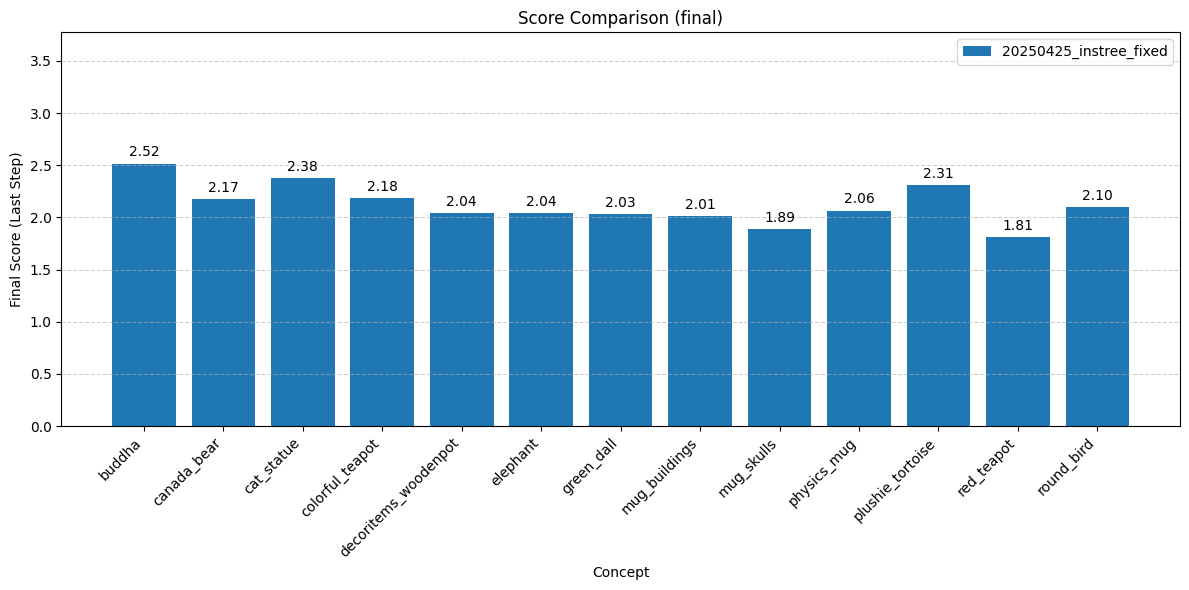

In [ ]:
def plot_concept_comparison(dict_list, field='final', title='Score Comparison'):
    title += " ({})".format(field)
    label_list = [dict.exp_name for dict in dict_list]
    
    # Get common concepts across all dictionaries
    concept_sets = [set(d.concept) for d in dict_list]
    common_concepts = sorted(set.intersection(*concept_sets))
    
    if not common_concepts:
        print("No common concepts to compare.")
        return

    n_dicts = len(dict_list)
    x = np.arange(len(common_concepts))
    width = 0.8 / n_dicts  # Adjust total bar width

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, (d, label) in enumerate(zip(dict_list, label_list)):
        scores = [d.data[c][field+"_score"] for c in common_concepts]
        bars = ax.bar(x + i * width - (n_dicts - 1) * width / 2, scores, width, label=label)
        
        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_xlabel('Concept')
    ax.set_ylabel('Final Score')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(common_concepts, rotation=45, ha='right')
    ylim = max(max([d.data[c][field+"_score"] for c in common_concepts]) for d in dict_list)  * 1.5
    ax.set_ylim(0, ylim)
    ax.legend(loc='best')

    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_concept_comparison([sk_list[0]])


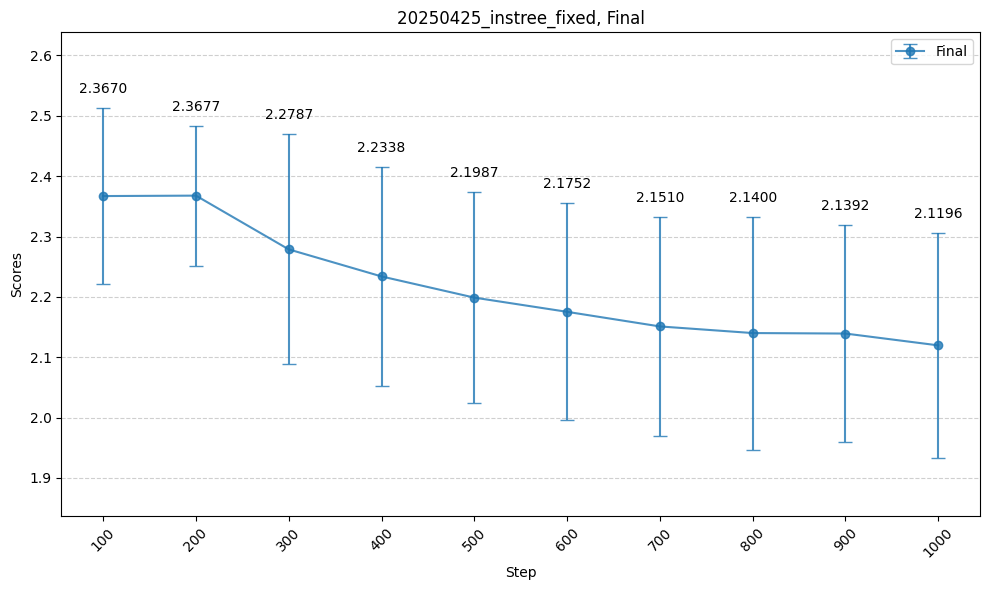

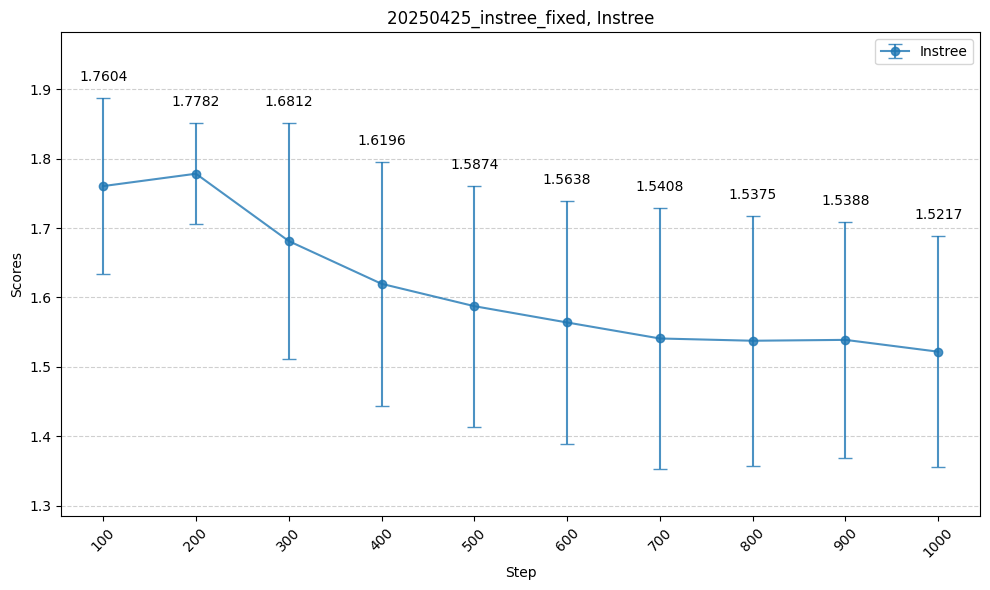

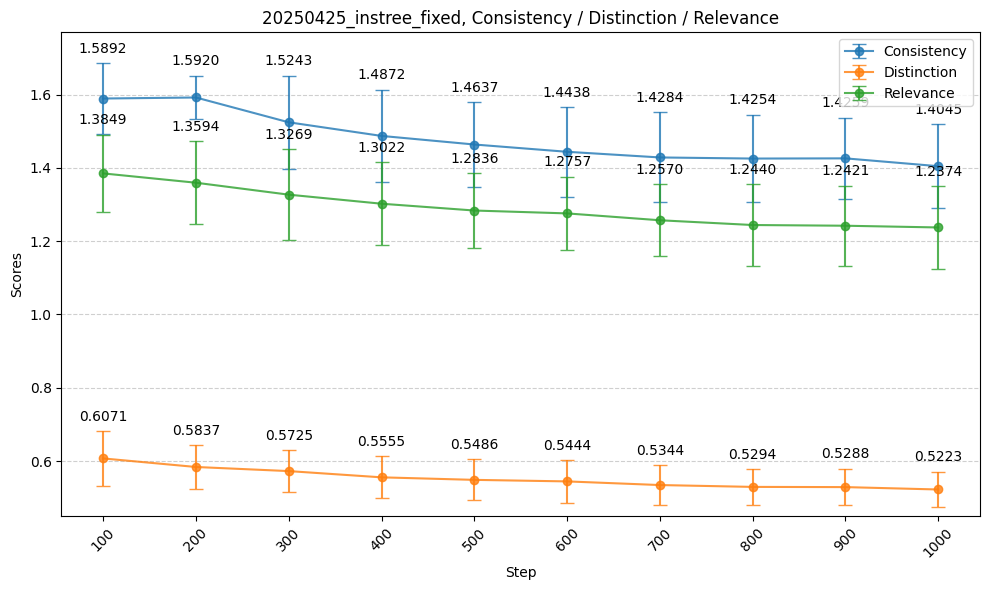

In [20]:
def plot_all_scores_one_plot(score_keepers, fields = ["consistency", "distinction", "relevance"]):
    # Extracting experiment names (x-axis labels)
    exp_names = [sk.exp_name for sk in score_keepers]

    # Consistency Score by Instree
    for sk in score_keepers:
        sk.calculate_instree_score()

    # Metrics data
    means = {
        metric: [getattr(sk, f"metric")["{}_score".format(metric)][0] for sk in score_keepers]
        for metric in fields
    }
    stds = {
        metric: [getattr(sk, f"metric")["{}_score".format(metric)][1] for sk in score_keepers]
        for metric in fields
    }

    x = np.arange(len(score_keepers))

    fig, ax = plt.subplots(figsize=(10, 6))

    # Line plots for each metric with error bars
    for metric in fields:
        ax.errorbar(
            x,
            means[metric],
            yerr=stds[metric],
            fmt='-o',
            capsize=5,
            label=metric.capitalize(),
            alpha=0.8
        )

        # Add numerical values on each point
        for i in range(len(score_keepers)):
            ax.text(x[i], means[metric][i] + stds[metric][i] + 0.02,
                    f'{means[metric][i]:.4f}', ha='center', va='bottom', fontsize=10)

    # Labels and Title
    ax.set_xlabel('Step')
    ax.set_ylabel('Scores')
    ax.set_title(f'{exp_name  + ", " + " / ".join([f.capitalize() for f in fields])}')
    # ax.set_title("InspirationTree Consistency Scores") 
    ax.set_xticks(x)
    ax.set_xticklabels(exp_names, rotation=45)
    ax.set_ylim(min(min(means[m][i] - stds[m][i] for i in range(len(x))) for m in fields) * 0.95,
                max(max(means[m][i] + stds[m][i] for i in range(len(x))) for m in fields) * 1.05)
    ax.legend()

    # Grid and Layout
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Example usage
exp_name = '20250524_last_rand_exp'
exp_name = '20250425_instree_fixed'
plot_all_scores_one_plot(sk_step_dict[exp_name], fields = ["final"])
plot_all_scores_one_plot(sk_step_dict[exp_name], fields = ["instree"])
plot_all_scores_one_plot(sk_step_dict[exp_name], fields = ["consistency", "distinction", "relevance"])

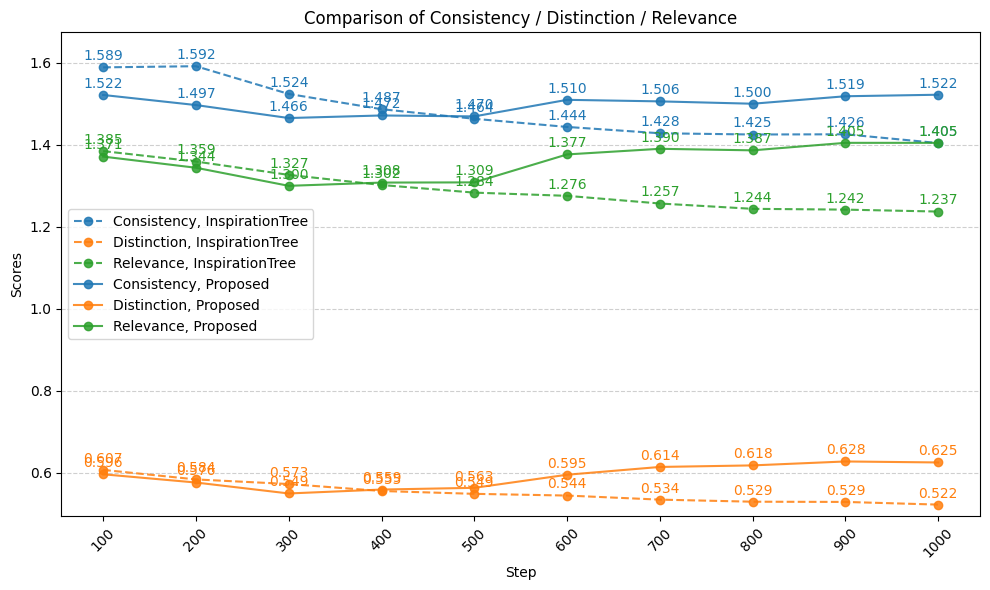

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_all_scores_one_plot_multi_exp(exp_dict, fields=["consistency", "distinction", "relevance"], show_error_bar=False):
    """
    exp_dict: a dictionary where key = experiment name, value = list of ScoreKeeper instances
    fields: list of metrics to plot
    """
    linestyles = ['--', '-', '-.', ':']
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    
    fig, ax = plt.subplots(figsize=(10, 6))

    # Iterate over experiments
    for exp_idx, (exp_name, score_keepers) in enumerate(exp_dict.items()):
        # Calculate scores if needed
        for sk in score_keepers:
            sk.calculate_instree_score()

        x = np.arange(len(score_keepers))
        exp_names = [sk.exp_name for sk in score_keepers]

        # Collect mean and std for each field
        means = {
            metric: [getattr(sk, f"metric")["{}_score".format(metric)][0] for sk in score_keepers]
            for metric in fields
        }
        stds = {
            metric: [getattr(sk, f"metric")["{}_score".format(metric)][1] for sk in score_keepers]
            for metric in fields
        }

        # Plot each field with a different linestyle, same color for this exp
        for field_idx, metric in enumerate(fields):
            color = colors[field_idx % len(linestyles)]
            linestyle = linestyles[exp_idx]
            labels = ['InspirationTree', 'Proposed']
            label = metric.capitalize() + ", " + labels[exp_idx]

            # label = f"{exp_name} - {metric}"
            if show_error_bar:
                ax.errorbar(
                    x,
                    means[metric],
                    yerr=stds[metric],
                    fmt='o',
                    linestyle=linestyle,
                    color=color,
                    capsize=4,
                    label=label,
                    alpha=0.85
                )
            else:
                ax.plot(
                    x,
                    means[metric],
                    marker='o',
                    linestyle=linestyle,
                    color=color,
                    label=label,
                    alpha=0.85
                )

            # Optional: show text value
            for i in range(len(score_keepers)):
                ax.text(x[i], means[metric][i] + (stds[metric][i] if show_error_bar else 0) + 0.01,
                        f'{means[metric][i]:.3f}', ha='center', va='bottom', fontsize=10, color=color)

    ax.set_xlabel('Step')
    ax.set_ylabel('Scores')
    ax.set_ylim(min(min(means[m][i] - stds[m][i] if show_error_bar else means[m][i] for i in range(len(x))) for m in fields) * 0.9,
            max(max(means[m][i] + stds[m][i] if show_error_bar else means[m][i] for i in range(len(x))) for m in fields) * 1.1)
    ax.set_title("Comparison of Scores across Multiple Experiments: " + ' / '.join([f.capitalize() for f in fields]))
    ax.set_title("Comparison of Final Score")
    ax.set_title("Comparison of " + ' / '.join([f.capitalize() for f in fields]))
    ax.set_xticks(x)
    ax.set_xticklabels(exp_names, rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example usage
plot_all_scores_one_plot_multi_exp(sk_step_dict, fields=["consistency", "distinction", "relevance"])#, "instree", "consistency", "distinction", "relevance"])


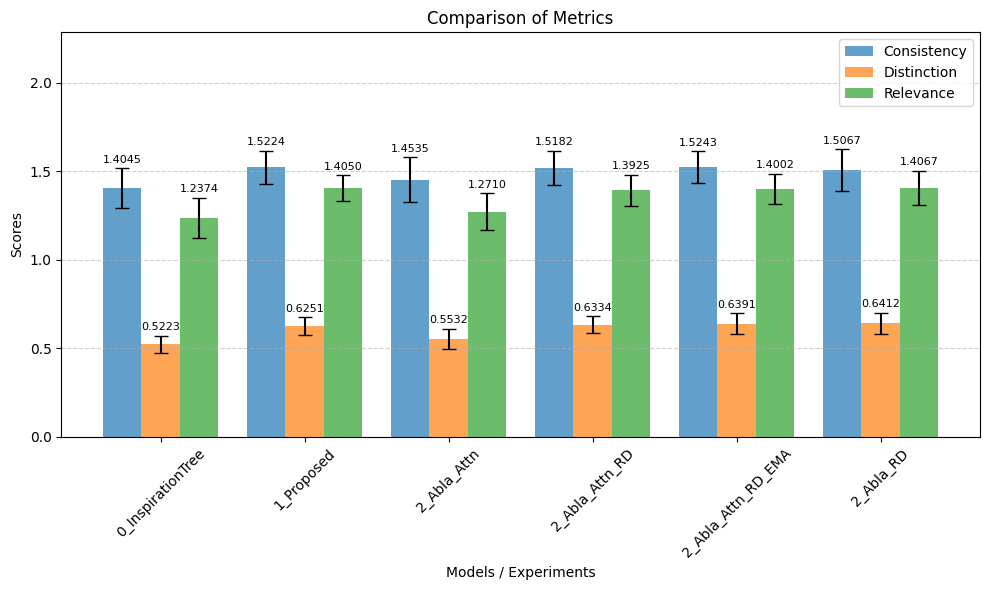

In [13]:
def plot_all_scores_one_plot(score_keepers, metrics_to_plot=["consistency", "distinction", "relevance", "final"]):
    # Extract model and experiment names
    model_names = [sk.model_name for sk in score_keepers]
    exp_names = [sk.exp_name for sk in score_keepers]

    # Extract means and stds for selected metrics
    means = {
        metric: [getattr(sk, f"metric")["{}_score".format(metric)][0] for sk in score_keepers]
        for metric in metrics_to_plot
    }
    stds = {
        metric: [getattr(sk, f"metric")["{}_score".format(metric)][1] for sk in score_keepers]
        for metric in metrics_to_plot
    }

    x = np.arange(len(score_keepers))  # base x locations for the bars
    n_metrics = len(metrics_to_plot)
    width = 0.8 / n_metrics  # bar width dynamically based on number of metrics

    fig, ax = plt.subplots(figsize=(10, 6))

    # Shift bar positions dynamically
    offsets = np.linspace(-width * (n_metrics - 1) / 2, width * (n_metrics - 1) / 2, n_metrics)

    for i, metric in enumerate(metrics_to_plot):
        bar_positions = x + offsets[i]
        ax.bar(bar_positions, means[metric], width, yerr=stds[metric], capsize=5,
               label=metric.capitalize(), alpha=0.7)

        # Add numerical value labels above each bar
        for j in range(len(score_keepers)):
            ax.text(bar_positions[j], means[metric][j] + stds[metric][j] + 0.02,
                    f'{means[metric][j]:.4f}', ha='center', va='bottom', fontsize=8)

    # Labels and Titles
    ax.set_xlabel('Models / Experiments')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(exp_names, rotation=45)

    max_score = max([max(means[metric]) for metric in metrics_to_plot])
    ax.set_ylim(0, max_score * 1.5)

    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_all_scores_one_plot(sk_list, metrics_to_plot=["consistency", "distinction", "relevance"])